##**SETUP**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


the fits file scales all values to be in the range 0, 65535 (256^2-1) so we need to create copied array with floats instead of int values to be able to adjust it wiht out extrapolated intensities

In [2]:
import numpy as np
import os
import math
from PIL import Image
import astropy
#%config InlineBackend.rc = {}
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from matplotlib.colors import LogNorm
from astropy.nddata.utils import Cutout2D
from skimage import data, feature
from skimage.color import rgb2gray
from skimage.feature import blob_log
import scipy
!pip install astroalign
import matplotlib.ticker as ticker
from matplotlib.colors import PowerNorm

# import warnings filter
from warnings import simplefilter
# ignore all future warnings -
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
from skimage.feature import blob_dog

In [3]:
def image_load(name,drive_location):
  '''function to load image from  google drive'''

  image_path = f'/content/drive/My Drive/{drive_location}/{name}.fit'
  hdulist = fits.open(image_path)
  image_data = hdulist[0].data
  return image_data

##**CREATING THE CLASS**

In [4]:
class ImageCorrector():
  '''
  Class that takes an astronomical image and corrects
  pixel values of bright stars that should be greater than 
  the telescope maximum of 65535 by fitting gaussians
  ''' 
  #-------------------------------------------------------------------------------------------------------------------#

  def star_detector(self, image_data, min_sigma=1, max_sigma=5, num_sigma=10, threshold=0.003, overlap=0.5, log_scale=True): 
    '''
    function to detect stars using blob_log
    increase max sigma to detect bigger stars, 
    reduce threshold to detect less bright stars

    For each blob found, the method returns its coordinates and the 
    standard deviation of the Gaussian kernel that detected the blob
    The radius of each blob is approximately 2*sqrt(σ) for a 2D image
    '''
    greyimg = rgb2gray(image_data) #only necessary for non-greyscale images 
    stars = blob_log(greyimg, min_sigma, max_sigma, num_sigma, threshold, overlap, log_scale)
    return stars

  #-------------------------------------------------------------------------------------------------------------------#

  def star_plotter(self, image_data, stars, nr_images):
    """
    function to plot image and circle detected stars
    image_data = tuple of data arrays(for constructing images)
    stars = tuple of arrays containing star coordinates and sigmas
    nr_images = same number of arrays in the above tuples 
    """
    fig, ax = plt.subplots(ncols = nr_images, figsize=(19,6))
    for i in range(nr_images): 
      ax[i].imshow(image_data[i], norm = PowerNorm(0.35), origin = 'lower', cmap='gray')
      for star in stars[i]:
        y, x, sigma = star
        ax[i].add_patch(plt.Circle((x, y), sigma*2.5, 
                    color='r', linewidth = 2, fill=False))

   #-------------------------------------------------------------------------------------------------------------------#  
    
  def cutout_star(self, ind, stars, image_data, size):
    """
    function to cutout square containing star
    ind = star index
    size = cutout size 
    """
    from astropy.nddata.utils import Cutout2D
    pos= (np.roll(stars[ind, 0:2],-1)).tolist() #extract position and reshape to (x, y), convert to list
    cutout = Cutout2D(image_data, pos, size, copy = True)
    cutout= np.asarray(cutout.data).astype(float)  
    return cutout

  #-------------------------------------------------------------------------------------------------------------------#

  def get_data(self, cutout, size):
    """
    function to get data array containing (radii, corresponding intensities)
    """
    centre = (math.ceil(size[0]/2), math.ceil(size[0]/2))
    x_c =int(centre[0])
    y_c = int(centre[1])
    intensities = np.zeros((cutout.size,1)) #array that will contain all pixel values in the cutout 
    radii = []
    count = 0
    for i in range(cutout.shape[0]):
      for j in range(cutout.shape[1]):
        r = np.sqrt((j-x_c)**2+(i-y_c)**2)
        radii.append(r)
        intensities[count] = cutout.data[i,j]
        count += 1
    radii = (np.asarray(radii)).reshape(len(radii), 1)
    data = np.concatenate((radii, intensities), axis =1)
    data = np.delete(data, np.where(data ==256**2-1), axis=0) #remove maxed out pixels so they dont distort the gaussian fit

    return data

  #-------------------------------------------------------------------------------------------------------------------#

  def gaussian_fit(self, data, cutout): 
    """
    function to fit gaussian to datapoints in cutout 
    """
    def func(r, a, sigma, b): 
      return a*np.exp((-r**2/(2*sigma**2)))+b

    xdata = np.array(data[:,0]).astype(float)
    ydata = data[:,1]

    popt, pcov = scipy.optimize.curve_fit(func, xdata.ravel(), ydata.ravel(), p0 = (65e3,5,1000)) 
    # fo p0 we specifiy an initial estimate for the params to avoid local minima

    #ACCESSING THE PARAMETERS 
    a = popt[0]
    sigma = popt[1]
    b = popt[2]

    #modifying the cutout 
    centre = (math.ceil(cutout.shape[0]/2), math.ceil(cutout.shape[0]/2))
    x_c =int(centre[0])
    y_c = int(centre[1])
    for i in range(cutout.shape[0]):
      for j in range(cutout.shape[1]):
        if cutout[i,j] == 256**2-1:
          r = np.sqrt((j-x_c)**2+(i-y_c)**2)
          intensity_correction = a*np.exp((-r**2/(2*sigma**2)))+b  
          cutout[i,j] = intensity_correction 
    total_flux = np.sum(cutout) #sum all intensities in cutout to get total flux of the star (background will be removed later )
    return cutout, total_flux, b

  #-------------------------------------------------------------------------------------------------------------------#
  
  def plot_og_vs_corrected(self, image_data, fixed_image_data):
    """
    function to plot the original vs corrected images
    """
    import matplotlib.ticker as ticker
    from matplotlib.colors import PowerNorm

    def fmt(x, pos):
      a, b = '{:.2e}'.format(x).split('e')
      b = int(b)
      return r'$10^{{{}}}$'.format(b)
    
    vmax = np.amax(fixed_image_data)

    fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
    img1= ax[0].imshow(image_data, norm = PowerNorm(0.25, vmin = 1, vmax=vmax))
    ax[0].set_title(f'Original Image, Max Intensity ={np.amax(image_data)}')


    img2= ax[1].imshow(fixed_image_data,norm = PowerNorm(0.25, vmin = 1, vmax=vmax))
    ax[1].set_title(f'Corrected Image, Max Intensity ={np.amax(fixed_image_data)}')
    #plt.colorbar(img1, ax = ax[0], ticks = [0, 10**2, 10**4, 10**5], format =ticker.FuncFormatter(fmt))
    plt.colorbar(img2, ax = ax[1], ticks = [0, 10**2, 10**4, 10**5], format =ticker.FuncFormatter(fmt))
    plt.tight_layout()
    plt.show()
  
  #-------------------------------------------------------------------------------------------------------------------#

  def return_to_image(self,position, image, size, cutout):
    """
    function to return intensity corrected star to original image 
    """
    startcoords0 = (position[0] - np.ceil(size[0]/2)).astype(int)
    endcoords0 = (position[0] + np.ceil(size[0]/2)).astype(int)
    startcoords1 = (position[1] - np.ceil(size[0]/2)).astype(int)
    endcoords1 = (position[1] + np.ceil(size[0]/2)).astype(int)

    if startcoords0 < 0:
      startcoords0 = 0
    if startcoords1 < 0:
      startcoords1 = 0
    if endcoords0 > image.shape[0]:
      endcoords0 = image.shape[0]
    if endcoords1 > image.shape[1]:
      endcoords1 = image.shape[1]

    image[startcoords0 : endcoords0, startcoords1 : endcoords1] = cutout 

    return image

  #-------------------------------------------------------------------------------------------------------------------#

  def __call__(self, image_data, size=(20,20), remove_background =True):
    
    stars = self.star_detector(image_data)
    flux_array = np.zeros((stars.shape[0],1))
    image = image_data.copy().astype(float) 

    for star in range(stars.shape[0]): 
      position = stars[star, 0:2]
      cutout = self.cutout_star(star, stars, image, size)
      data  = self.get_data(cutout, size)
      cutout, total_flux, b = self.gaussian_fit(data, cutout)
      flux_array[star] = total_flux
      image = self.return_to_image(position, image, size, cutout)

    if remove_background:
      image = image - 3500
      image[image<0] = 0

      flux_array = flux_array -b*cutout.size
    
    fixed_image = image.astype(int)
    stars_and_flux = np.concatenate((stars, flux_array), axis = 1)
    return fixed_image, stars_and_flux

IC = ImageCorrector()



##**LOADING IMAGES AND DETECTING STARS**

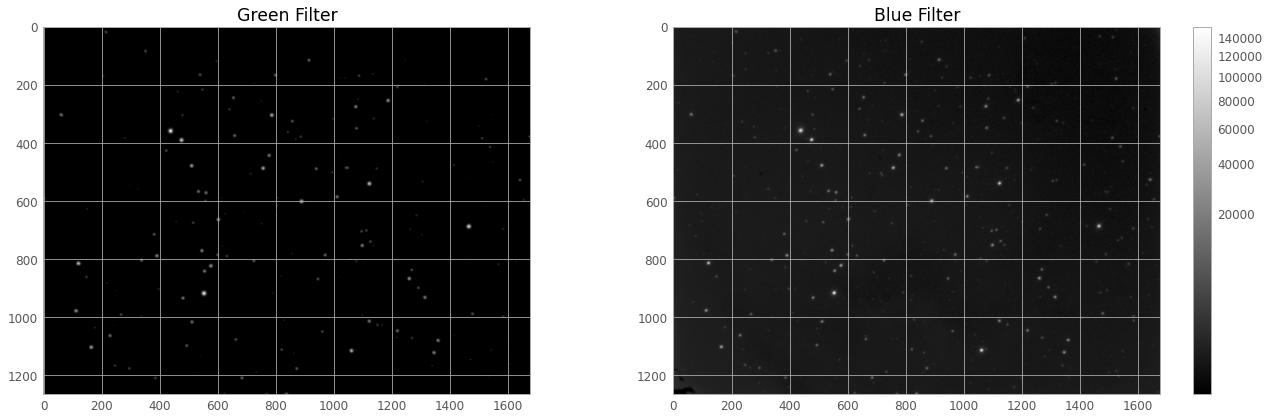

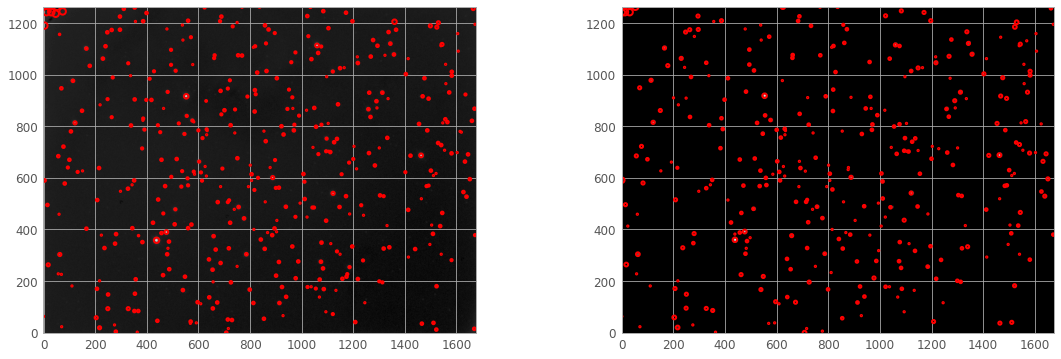

Green Minimum: 0
Blue Minimum: 0


In [5]:
size = (10,10) #cutout size

#LOADING IMAGES
green =image_load('M35_1290_1293green', '3YP/M35Tracking/Run3')
blue = image_load('M35_1290_1293blue', '3YP/M35Tracking/Run3')

corr_green, g_stars_and_flux = IC(green, size)
corr_blue, b_stars_and_flux = IC(blue, size)

#PLOTTING
fig, ax = plt.subplots(ncols = 2, figsize = (19,6))
vmax =np.max(np.concatenate((corr_blue, corr_green)))
img1 = ax[0].imshow(corr_blue, norm = PowerNorm(0.35, vmin =0.1, vmax=vmax),cmap = 'gray')
ax[0].set_title('Green Filter')
img2= ax[1].imshow(corr_green, norm = PowerNorm(0.35, vmin=0.1, vmax=vmax), cmap= 'gray')
ax[1].set_title('Blue Filter')
plt.colorbar(img2)
plt.tight_layout()

IC.star_plotter(image_data =(corr_green, corr_blue), stars =(g_stars_and_flux[:, 0:3], b_stars_and_flux[:,0:3]), nr_images=2)
plt.show()
print('Green Minimum:', np.amin(corr_blue))
print('Blue Minimum:',np.amin(corr_green))

In [6]:
print(len(g_stars_and_flux))
print(len(b_stars_and_flux))

424
341


##**PAIRING STARS AND CALCULATING MAGNITUDES**

In [75]:
def pair_stars_and_compute_mags(g_stars_and_flux, b_stars_and_flux, t=4):
  B_V = []
  m_v = []
  for i in range(len(g_stars_and_flux)):
    for j in range(len(b_stars_and_flux)):
      #we accept two stars as identical if they arent more than sqrt(t) pixels apart in any direction
      if np.square(g_stars_and_flux[i, 0]- b_stars_and_flux[j,0]) <= t and np.square(g_stars_and_flux[i, 1]- b_stars_and_flux[j,1]) <=t:
        bv = -2.5*np.log10(b_stars_and_flux[j,3]/g_stars_and_flux[i, 3])
        if bv <= 2:
          B_V.append(bv)
          m_v.append(-2.5 * np.log10(g_stars_and_flux[i,3]))
  return B_V, m_v

B_V, m_v = pair_stars_and_compute_mags(g_stars_and_flux, b_stars_and_flux)

##**PLOTTING HR DIAGRAMS**

###**Apparent Magnitudes**

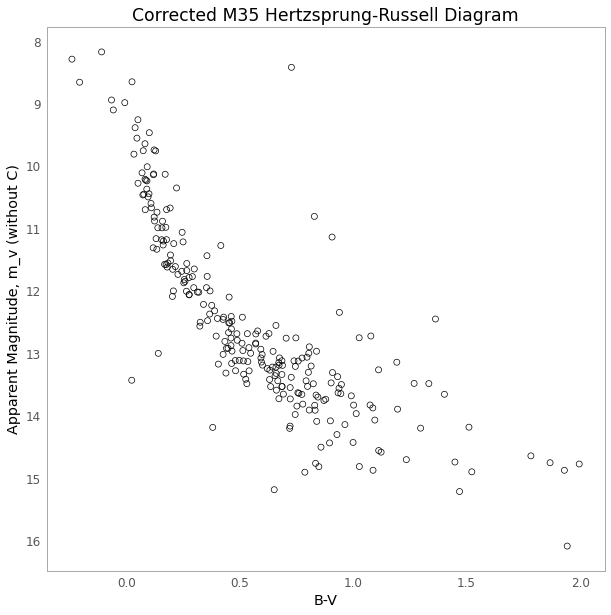

In [76]:
#ADD CONSTANT TO ALL VALUES IN m_v
c = 25
corr_m_v = [i+c for i in m_v] 

#PLOT
plt.close()
plt.scatter(B_V, corr_m_v, marker='o',facecolors='none',edgecolors = 'black', linewidth=0.7)
plt.gca().invert_yaxis()
plt.rcParams["figure.figsize"] = (10,10)
plt.title('Corrected M35 Hertzsprung-Russell Diagram')
plt.xlabel('B-V')
plt.ylabel('Apparent Magnitude, m_v (without C)')
plt.grid(False)

###**Absolute Magnitudes**

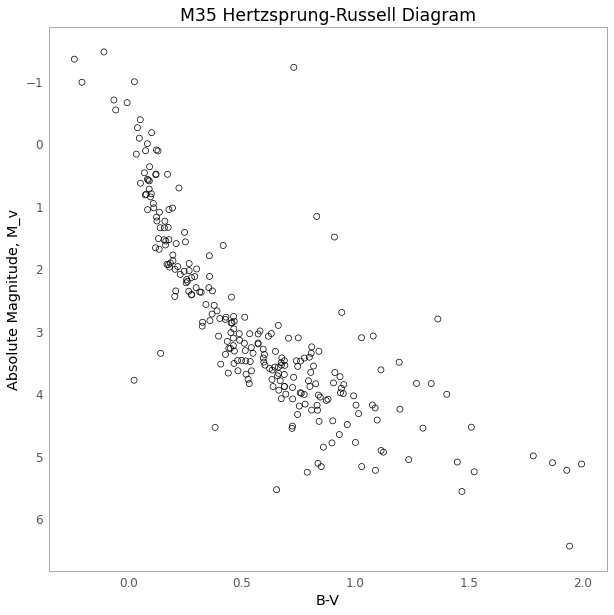

In [73]:
#COMPUTE ABSOLUTE MAGNITUDES
abs_mags = []
d = 850
for app_mag in m_v: 
  abs_mag = app_mag + 5 - 5*np.log10(d) + c
  abs_mags.append(abs_mag)

#PLOT
plt.close()
from matplotlib.pyplot import figure
plt.scatter(B_V, abs_mags, marker='o',facecolors='none',edgecolors = 'black', linewidth=0.7)
plt.gca().invert_yaxis()
plt.rcParams["figure.figsize"] = (10,10)
plt.title('M35 Hertzsprung-Russell Diagram')
plt.xlabel('B-V')
plt.ylabel('Absolute Magnitude, M_v')
plt.grid(False)

###**Temperatures and Luminosities**

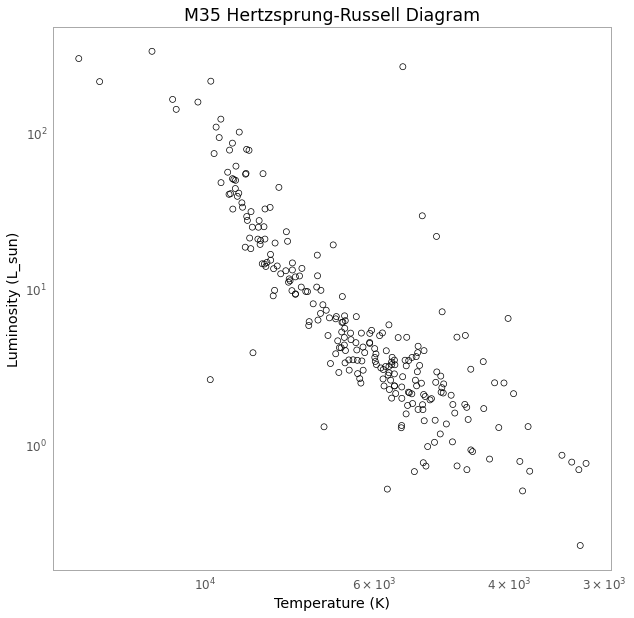

In [74]:
from matplotlib.ticker import ScalarFormatter

#COMPUTE TEMPERATURES
T = []
for i in B_V: 
  #temp = 7000/((i)+0.6)
  temp = 4600*(1/(0.92*i+1.7)+1/(0.92*i+0.62))    
  T.append(temp)

#COMPUTE LUMINOSITIES
L = []
for i in abs_mags:
  lum = 10**(0.4*(4.83-i))
  L.append(lum)

#PLOT
plt.close()
plt.scatter(T, L, marker='o',facecolors='none',edgecolors = 'black', linewidth=0.7)
plt.xscale('log')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.rcParams["figure.figsize"] = (10,10)
plt.title('M35 Hertzsprung-Russell Diagram')
plt.xlabel('Temperature (K)')
plt.ylabel('Luminosity (L_sun)')
plt.tick_params(bottom = True)
ax = plt.gca()
plt.grid(False)
plt.show()